In [1]:
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from dateutil import parser
from wordcloud import WordCloud
from scripts import MONGO_URL
from scripts.analysis import data, plot

plot.init_matplotlib()


def get_corpus(repo_names: list[str]) -> tuple[dict[str, int], list[list[str]]]:
    word_freq = {}
    text_corpora = []
    for repo in repo_names:
        repo_name = repo.split("/")[1]
        text = []
        for x in repo_name.split("-"):
            for y in x.split("_"):
                for word in y.split("."):
                    if len(word) <= 1:
                        continue
                    word = word.lower()
                    if word in word_freq:
                        word_freq[word] += 1
                        text.append(word)
                    else:
                        word_freq[word] = 1
                        text.append(word)
        if len(text) > 0:
            text_corpora.append(text)
    return word_freq, text_corpora

In [2]:
repos = data.get_fake_star_repos()
repos_with_campaign = data.get_repos_with_campaign()
repos = repos[repos.repo_name.isin(repos_with_campaign)]
print(len(repos[repos.repo_id.notna()]), len(repos[repos.repo_id.isna()]))

1783 16834


[('2024', 1408), ('bot', 1149), ('free', 874), ('crack', 725), ('pro', 665), ('adobe', 627), ('auto', 535), ('activation', 469), ('autoclicker', 449), ('hack', 362), ('executor', 323), ('crypto', 320), ('cracked', 264), ('ai', 262), ('cheat', 260), ('version', 258), ('roblox', 256), ('wallet', 250), ('generator', 244), ('studio', 244), ('download', 236), ('main', 232), ('tool', 225), ('for', 211), ('h4ck', 197), ('premium', 195), ('trading', 184), ('app', 184), ('photoshop', 177), ('discord', 172), ('fl', 170), ('script', 163), ('by', 158), ('full', 156), ('solara', 155), ('clicker', 151), ('menu', 147), ('solana', 144), ('blum', 142), ('sniper', 136), ('vpn', 124), ('video', 121), ('apex', 118), ('game', 118), ('pc', 117), ('rust', 116), ('fr33', 116), ('view', 113), ('hamster', 110), ('seed', 106)]


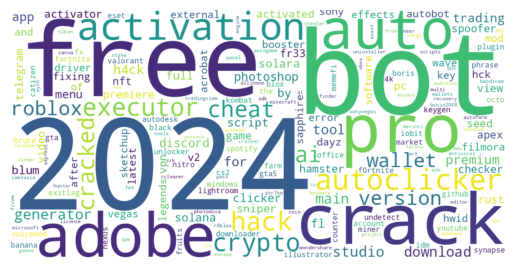

In [3]:
# all repos
word_freq, text_corpora = get_corpus(repos_with_campaign)
print(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:50])
wordcloud = WordCloud(
    width=1200, height=600, background_color="white", colormap="viridis"
).generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("plots/wordcloud.pdf", bbox_inches="tight")

[('2024', 1382), ('bot', 1071), ('free', 856), ('crack', 721), ('pro', 656), ('adobe', 618), ('auto', 528), ('activation', 467), ('autoclicker', 438), ('hack', 357), ('executor', 321), ('crypto', 312), ('cracked', 263), ('cheat', 256), ('version', 254), ('roblox', 252), ('ai', 245), ('wallet', 241), ('studio', 239), ('generator', 235), ('download', 234), ('main', 226), ('tool', 216), ('for', 200), ('h4ck', 196), ('premium', 192), ('photoshop', 177), ('trading', 175), ('fl', 168), ('discord', 163), ('script', 160), ('app', 159), ('by', 157), ('solara', 154), ('full', 151), ('clicker', 148), ('menu', 147), ('blum', 141), ('vpn', 121), ('apex', 117), ('video', 117), ('solana', 116), ('sniper', 116), ('pc', 113), ('fr33', 113), ('hamster', 109), ('game', 109), ('rust', 107), ('view', 106), ('activator', 105), ('activated', 104), ('seed', 103), ('premiere', 101), ('checker', 100), ('nft', 96), ('spoofer', 94), ('vegas', 93), ('sony', 91), ('sketchup', 87), ('key', 87), ('hwid', 86), ('acrob

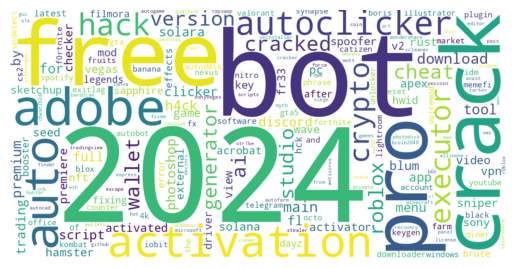

In [4]:
# deleted repos
word_freq, text_corpora = get_corpus(
    repos_with_campaign & set(repos[repos.repo_id.isna()].repo_name)
)
print(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:100])
wordcloud = WordCloud(
    width=1200, height=600, background_color="white", colormap="viridis"
).generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("plots/wordcloud-deleted.pdf", bbox_inches="tight")

[('bot', 78), ('sdk', 33), ('telegram', 32), ('solana', 28), ('2024', 26), ('app', 25), ('api', 24), ('did', 22), ('github', 21), ('sniper', 20), ('project', 20), ('android', 18), ('free', 18), ('server', 17), ('ai', 17), ('token', 16), ('products', 16), ('dart', 15), ('face', 15), ('web', 14)]


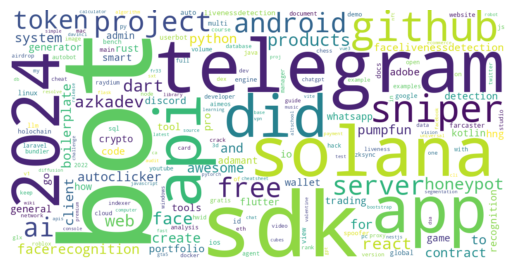

In [5]:
# non-deleted repos
word_freq, text_corpora = get_corpus(
    repos_with_campaign & set(repos[repos.repo_id.notna()].repo_name)
)
print(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20])
wordcloud = WordCloud(
    width=1200, height=600, background_color="white", colormap="viridis"
).generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("plots/wordcloud-nondeleted.pdf", bbox_inches="tight")

In [6]:
repo_labels = pd.read_csv("data/repo_labels.csv")

repo_labels.domain = repo_labels.domain.map(
    lambda x: x if x not in ["deleted", "bot"] else "other"
)

all_ = Counter(repo_labels.domain)
trending = Counter(repo_labels[repo_labels.trending].domain)
package = Counter(repo_labels[repo_labels.packages].domain)
other = Counter(repo_labels[~repo_labels.packages & ~repo_labels.trending].domain)

print(
    sum(all_.values()),
    sum(trending.values()),
    sum(package.values()),
    sum(other.values()),
)

table = []
for label, count in sorted(all_.items(), key=lambda x: x[1], reverse=True):
    table.append(
        {
            "label": label,
            "all": f"{count} ({count / sum(all_.values()) * 100:.1f}%)",
            "trending": f"{trending[label]} ({trending[label] / sum(trending.values()) * 100:.1f}%)",
            "package": f"{package[label]} ({package[label] / (sum(package.values()) + 1) * 100:.1f}%)",
            "other": f"{other[label]} ({other[label] / sum(other.values()) * 100:.1f}%)",
        }
    )
pd.DataFrame(table).set_index("label")

580 78 228 299


,all,trending,package,other
label,,,,
suspicious,131 (22.6%),16 (20.5%),22 (9.6%),93 (31.1%)
ai,96 (16.6%),25 (32.1%),36 (15.7%),45 (15.1%)
blockchain,76 (13.1%),10 (12.8%),44 (19.2%),30 (10.0%)
tool/application,73 (12.6%),15 (19.2%),22 (9.6%),39 (13.0%)
tutorial/demo,70 (12.1%),4 (5.1%),6 (2.6%),61 (20.4%)
web,56 (9.7%),5 (6.4%),44 (19.2%),9 (3.0%)
other,34 (5.9%),3 (3.8%),17 (7.4%),15 (5.0%)
basic-utility,30 (5.2%),0 (0.0%),27 (11.8%),3 (1.0%)
database,14 (2.4%),0 (0.0%),10 (4.4%),4 (1.3%)
